# Lab for different llama models and inference with dataset to create summary

In [1]:
# # if run in colab
# from google.colab import drive
# drive.mount('/content/drive')
# cd drive/MyDrive/PubPulse
# pwd
# import sys
# sys.path.append('/content/drive/MyDrive/PubPulse/lib')
# sys.path.append('/content/drive/MyDrive/PubPulse/data')
# sys.path.append('/content/drive/MyDrive/PubPulse/services')

In [28]:
import sys
sys.path.append("..")
sys.path.append("../lib")
sys.path.append("../data")
sys.path.append("../services")
sys.path.append("../models")
import importlib
import time
import preproc as pre
importlib.reload(pre)
import search_service as search
importlib.reload(search)
import os
import pandas as pd

# preprocess

In [29]:
dataset = pre.make_dataset_from_txt('../data/extracted-text/')

In [30]:
len(dataset)

299

In [31]:
dataset.head()

,type,title,input,data_source
0,ABSTRACT,ABSTRACT,ABSTRACT\n Medicine relies on the use of pharm...,Emerging Frontiers in Drug Delivery.txt
1,TITLE_PARAGRAPH,INTRODUCTION,Medicine relies on the use of pharmacologicall...,Emerging Frontiers in Drug Delivery.txt
2,TITLE_PARAGRAPH,DRUG DELIVERY SYSTEMS FOR CONTROLLED,RELEASE One important class of DDS is controll...,Emerging Frontiers in Drug Delivery.txt
3,TITLE_PARAGRAPH,SYSTEMIC RNA DELIVERY,RNAs can manipulate gene expression through se...,Emerging Frontiers in Drug Delivery.txt
4,TITLE_PARAGRAPH,DRUG DELIVERY SYSTEMS FOR LOCALIZED THERAPY,One potential limitation to systemic administr...,Emerging Frontiers in Drug Delivery.txt


In [32]:
dataset['input_redact'] = dataset['input'].apply(pre.redact_specified_parts)

In [33]:
dataset.head()

,type,title,input,data_source,input_redact
0,ABSTRACT,ABSTRACT,ABSTRACT\n Medicine relies on the use of pharm...,Emerging Frontiers in Drug Delivery.txt,ABSTRACT\n Medicine relies on the use of pharm...
1,TITLE_PARAGRAPH,INTRODUCTION,Medicine relies on the use of pharmacologicall...,Emerging Frontiers in Drug Delivery.txt,Medicine relies on the use of pharmacologicall...
2,TITLE_PARAGRAPH,DRUG DELIVERY SYSTEMS FOR CONTROLLED,RELEASE One important class of DDS is controll...,Emerging Frontiers in Drug Delivery.txt,RELEASE One important class of DDS is controll...
3,TITLE_PARAGRAPH,SYSTEMIC RNA DELIVERY,RNAs can manipulate gene expression through se...,Emerging Frontiers in Drug Delivery.txt,RNAs can manipulate gene expression through se...
4,TITLE_PARAGRAPH,DRUG DELIVERY SYSTEMS FOR LOCALIZED THERAPY,One potential limitation to systemic administr...,Emerging Frontiers in Drug Delivery.txt,One potential limitation to systemic administr...


In [34]:
combined_text = ' '.join(dataset[(dataset.data_source == 'Emerging Frontiers in Drug Delivery.txt') &\
                                  (dataset.type != 'ABSTRACT')].input_redact.tolist())

In [37]:
_, df_pdf = pre.convert_pdf_to_txt('../data/raw-pdf/PMC8198544.pdf')

In [38]:
paragraphs = dataset[(dataset.data_source == 'Emerging Frontiers in Drug Delivery.txt') &\
                                  (dataset.type != 'ABSTRACT')].input_redact.tolist()
paragraphs = [paragraph for paragraph in paragraphs if len(paragraph) > 100]

In [39]:
for paragraph in paragraphs:
    print(len(paragraph))

1169
962
689
2776
691
718
2648
214


In [40]:
from transformers import AutoTokenizer
# 1. Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("NousResearch/Llama-2-7b-hf")

In [41]:
paragraphs_token_counts = [len(tokenizer.tokenize(text)) for text in paragraphs]

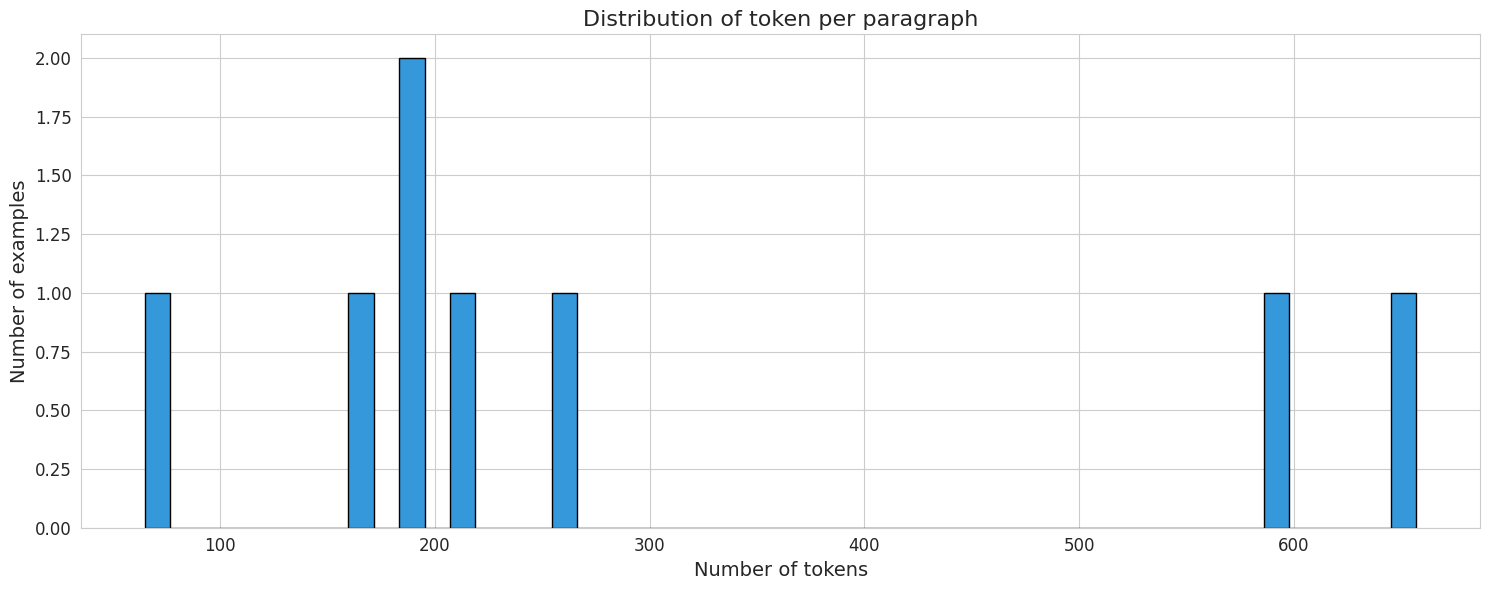

In [42]:
pre.plot_token_distribution(paragraphs_token_counts,
                            "Distribution of token per paragraph")

We must deal with the paragraphs that exceed the token limit of **512** the model `llama-2-7b.Q2_K.gguf`.

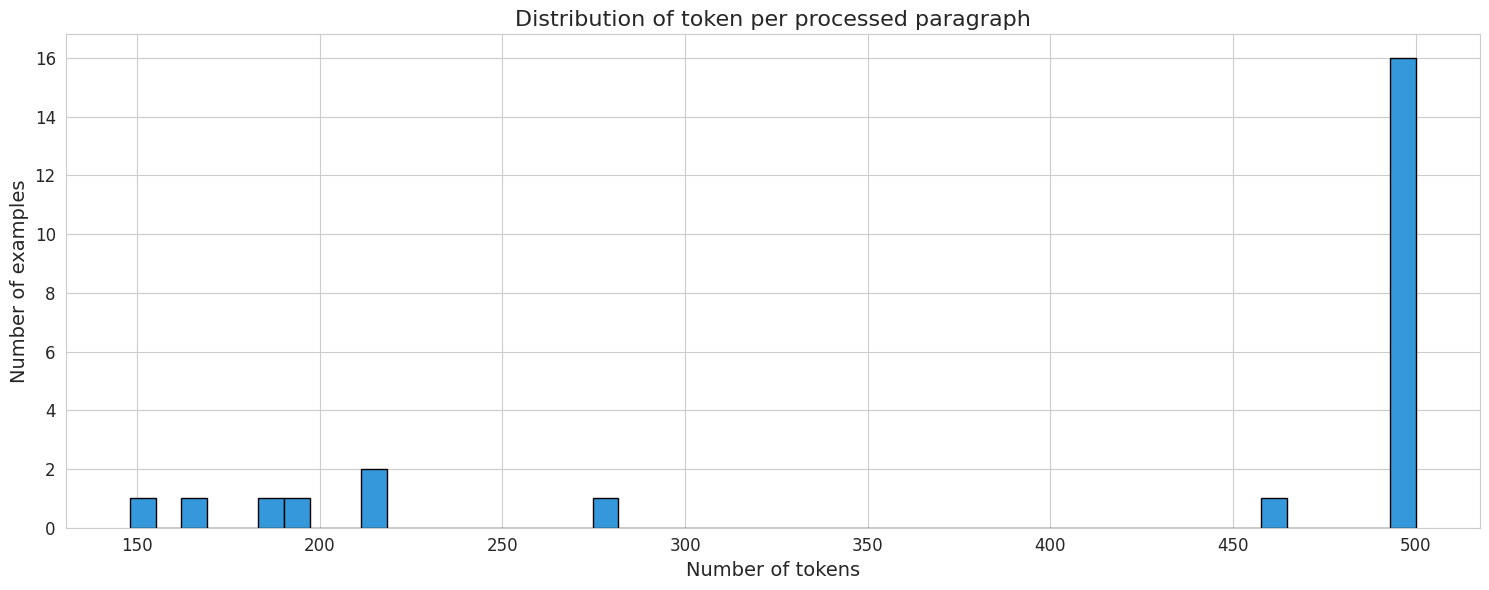

In [43]:
# Splitting and filtering the paragraphs
processed_paragraphs = pre.split_and_filter_paragraphs(paragraphs)

processed_paragraphs_lengths = [len(p) for p in processed_paragraphs]
pre.plot_token_distribution(processed_paragraphs_lengths,
                            "Distribution of token per processed paragraph")

# Llama-2-7b.Q2_K.gguf

In [44]:
from llama_cpp import Llama
llm = Llama(model_path="../models/llama-2-7b.Q2_K.gguf")

llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../models/llama-2-7b.Q2_K.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q2_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q3_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight q3_K     [  4096, 11008,     1,     1 ]
llama_model_loader: - tensor    4:              blk.0.ffn_up.weight q3_K     [  4096, 11008,     1,     1 ]
llama_model_loader: - tensor    5:            blk.0.ffn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    6:              blk.0.attn_k.weight q2_K     [  4096,  4096,     1,     1 ]
llama_model_loader: - tensor    7:         blk.0.attn_output.weight q3_K     [  4096,  4096,     1,     1 ]
llama

In [46]:
# Start timing
start_time = time.time()

from tqdm import tqdm  # Import tqdm

summary = []
for paragraph in tqdm(processed_paragraphs, desc="Summarizing paragraphs"):
    # Tokenize the individual paragraph to check its length
    tokens = tokenizer.tokenize(paragraph)
    
    # Skip paragraphs that are too long
    if len(tokens) > 512:
        continue

    # Correctly format the prompt with the current paragraph
    formatted_prompt = "Q: Create a summary of this {}. Summary: ".format(paragraph)
    
    # Generate summary
    output = llm(
        formatted_prompt,
        max_tokens=150,
        stop=["Q:", "\n"],
        echo=False
    )
    
    generated_text = output['choices'][0]['text']
    summary_index = generated_text.find("Summary:")
    summary_text = generated_text[summary_index + len("Summary:"):].strip()
    
    print(summary_text)
    print("-----------")
    
    summary.append(summary_text)

combined_summary = ' '.join(summary)
print(combined_summary)

# End timing
end_time = time.time()

# Calculate elapsed time in minutes
elapsed_time_minutes = (end_time - start_time) / 60

Summarizing paragraphs:   0%|                                                  | 0/24 [00:00<?, ?it/s]
llama_print_timings:        load time =   73576.02 ms
llama_print_timings:      sample time =      33.33 ms /    38 runs   (    0.88 ms per token,  1139.98 tokens per second)
llama_print_timings: prompt eval time =   73575.73 ms /   132 tokens (  557.39 ms per token,     1.79 tokens per second)
llama_print_timings:        eval time =   27912.02 ms /    37 runs   (  754.38 ms per token,     1.33 tokens per second)
llama_print_timings:       total time =  101756.22 ms
Summarizing paragraphs:   4%|█▋                                       | 1/24 [01:41<39:00, 101.76s/it]Llama.generate: prefix-match hit


tion. This summary of a comprehensive review article examines the current knowledge of the pharmacokinetic basis for the use of medication in children with cancer.
-----------



llama_print_timings:        load time =   73576.02 ms
llama_print_timings:      sample time =      71.23 ms /    74 runs   (    0.96 ms per token,  1038.83 tokens per second)
llama_print_timings: prompt eval time =   62871.51 ms /   114 tokens (  551.50 ms per token,     1.81 tokens per second)
llama_print_timings:        eval time =   54925.22 ms /    73 runs   (  752.40 ms per token,     1.33 tokens per second)
llama_print_timings:       total time =  118301.75 ms
Summarizing paragraphs:   8%|███▍                                     | 2/24 [03:40<40:52, 111.49s/it]Llama.generate: prefix-match hit


ule filling is one of the most important unit operations performed at pharmaceutical plants where bulk powder substances are converted into dosage forms such as tablets, capsules, sachets etc. 2. Filling equipment usually consists of a hopper, filler head and trays for each product to be filled
-----------



Summarizing paragraphs:  12%|█████▏                                   | 3/24 [05:49<41:53, 119.71s/it]llama_print_timings:        load time =   73576.02 ms
llama_print_timings:      sample time =     144.47 ms /   150 runs   (    0.96 ms per token,  1038.26 tokens per second)
llama_print_timings: prompt eval time =   27933.99 ms /    41 tokens (  681.32 ms per token,     1.47 tokens per second)
llama_print_timings:        eval time =  100458.57 ms /   149 runs   (  674.22 ms per token,     1.48 tokens per second)
llama_print_timings:       total time =  129479.20 ms
Llama.generate: prefix-match hit


1,2].  The primary purpose for using DDS is to prolong the residence time of an agent in its site of action by limiting its elimination from that site or by increasing its uptake by facilitating diffusion through tissue barriers (e.g., skin).  4.1.4 Intradermal Immunization Intradermal immunization is defined as the delivery of antigen to the skin. It is the preferred method for administration of vaccines in humans and has been used clinically since 1930, when it was first introduced for human poliomyelitis (type I) [1]. The current standardized device for intrad
-----------



llama_print_timings:        load time =   73576.02 ms
llama_print_timings:      sample time =       0.68 ms /     1 runs   (    0.68 ms per token,  1479.29 tokens per second)
llama_print_timings: prompt eval time =   64180.46 ms /   126 tokens (  509.37 ms per token,     1.96 tokens per second)
llama_print_timings:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_print_timings:       total time =   64184.59 ms
Summarizing paragraphs:  17%|███████                                   | 4/24 [06:53<32:35, 97.79s/it]Llama.generate: prefix-match hit



-----------



llama_print_timings:        load time =   73576.02 ms
llama_print_timings:      sample time =      54.45 ms /    58 runs   (    0.94 ms per token,  1065.26 tokens per second)
llama_print_timings: prompt eval time =   62081.88 ms /   103 tokens (  602.74 ms per token,     1.66 tokens per second)
llama_print_timings:        eval time =   33866.69 ms /    57 runs   (  594.15 ms per token,     1.68 tokens per second)
llama_print_timings:       total time =   96306.13 ms
Summarizing paragraphs:  21%|████████▊                                 | 5/24 [08:30<30:47, 97.26s/it]Llama.generate: prefix-match hit


fundamental concepts behind DDS are inextricably linked to their chemical structure. 2. The physical shape and size of these materials can also affect them dramatically. 3. Targeting the body's immune system is an essential component of these materials.
-----------



llama_print_timings:        load time =   73576.02 ms
llama_print_timings:      sample time =       0.96 ms /     1 runs   (    0.96 ms per token,  1040.58 tokens per second)
llama_print_timings: prompt eval time =   70845.35 ms /   144 tokens (  491.98 ms per token,     2.03 tokens per second)
llama_print_timings:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_print_timings:       total time =   70852.15 ms
Summarizing paragraphs:  25%|██████████▌                               | 6/24 [09:40<26:29, 88.28s/it]Llama.generate: prefix-match hit



-----------



llama_print_timings:        load time =   73576.02 ms
Summarizing paragraphs:  29%|████████████▎                             | 7/24 [10:08<19:26, 68.60s/it]llama_print_timings:      sample time =       0.70 ms /     1 runs   (    0.70 ms per token,  1430.62 tokens per second)
llama_print_timings: prompt eval time =   28082.86 ms /    56 tokens (  501.48 ms per token,     1.99 tokens per second)
llama_print_timings:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_print_timings:       total time =   28086.50 ms
Llama.generate: prefix-match hit



-----------



Summarizing paragraphs:  33%|██████████████                            | 8/24 [11:55<21:32, 80.80s/it]llama_print_timings:        load time =   73576.02 ms
llama_print_timings:      sample time =      99.44 ms /   150 runs   (    0.66 ms per token,  1508.46 tokens per second)
llama_print_timings: prompt eval time =   57969.39 ms /   119 tokens (  487.14 ms per token,     2.05 tokens per second)
llama_print_timings:        eval time =   48311.84 ms /   149 runs   (  324.24 ms per token,     3.08 tokens per second)
llama_print_timings:       total time =  106925.49 ms
Llama.generate: prefix-match hit


polymer used in the study is composed of a 45:25:30 mole ratio of poly(D-Lactide), poly(ε-caprolactone) and poly(glycolic acid) (PLA, PCL, PGA) respectively. 2. The depot was created using a double injection method with a 10 mg BCNU dose per shot, into the right side of the abdominal cavity wall. The depot was placed on top of the lateral rectus muscle. 3. After three weeks there were no signs of inflammation around the implant site and the histology confirmed the lack of inflammatory reaction
-----------



Summarizing paragraphs:  38%|███████████████▊                          | 9/24 [12:34<16:51, 67.45s/it]llama_print_timings:        load time =   73576.02 ms
llama_print_timings:      sample time =       0.67 ms /     1 runs   (    0.67 ms per token,  1492.54 tokens per second)
llama_print_timings: prompt eval time =   38067.72 ms /   136 tokens (  279.91 ms per token,     3.57 tokens per second)
llama_print_timings:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_print_timings:       total time =   38075.35 ms
Llama.generate: prefix-match hit



-----------



llama_print_timings:        load time =   73576.02 ms
llama_print_timings:      sample time =      49.13 ms /    71 runs   (    0.69 ms per token,  1445.12 tokens per second)
llama_print_timings: prompt eval time =   48299.77 ms /   124 tokens (  389.51 ms per token,     2.57 tokens per second)
llama_print_timings:        eval time =   25011.83 ms /    70 runs   (  357.31 ms per token,     2.80 tokens per second)
llama_print_timings:       total time =   73633.39 ms
Summarizing paragraphs:  42%|█████████████████                        | 10/24 [13:47<16:11, 69.36s/it]

IP-10 is an excellent candidate for the delivery of targeted radionuclide therapy for the treatment of neuroendocrine tumors, both because its high affinity to somatostatin receptors and because it can be administered safely via a simple i. v. injection.
-----------


Llama.generate: prefix-match hit

Summarizing paragraphs:  46%|██████████████████▊                      | 11/24 [14:45<14:17, 65.99s/it]llama_print_timings:        load time =   73576.02 ms
llama_print_timings:      sample time =      42.36 ms /    55 runs   (    0.77 ms per token,  1298.52 tokens per second)
llama_print_timings: prompt eval time =   31385.71 ms /   115 tokens (  272.92 ms per token,     3.66 tokens per second)
llama_print_timings:        eval time =   26641.31 ms /    54 runs   (  493.36 ms per token,     2.03 tokens per second)
llama_print_timings:       total time =   58347.39 ms
Llama.generate: prefix-match hit


ease the temperature of a material by more than Tg and it becomes unstable. 2) The temperature will decrease by more than Tg (decrease in Tg) and the material is stable until annealed to room temperature.
-----------



llama_print_timings:        load time =   73576.02 ms
Summarizing paragraphs:  50%|████████████████████▌                    | 12/24 [15:26<11:38, 58.23s/it]llama_print_timings:      sample time =       0.64 ms /     1 runs   (    0.64 ms per token,  1567.40 tokens per second)
llama_print_timings: prompt eval time =   40472.10 ms /   129 tokens (  313.74 ms per token,     3.19 tokens per second)
llama_print_timings:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_print_timings:       total time =   40476.18 ms
Llama.generate: prefix-match hit



-----------


Summarizing paragraphs:  54%|██████████████████████▏                  | 13/24 [15:54<09:01, 49.22s/it]

mechanical properties of these hydrogels are designed to be more flexible than native tissue while retaining sufficient rigidity.
-----------



llama_print_timings:        load time =   73576.02 ms
llama_print_timings:      sample time =      20.60 ms /    29 runs   (    0.71 ms per token,  1407.97 tokens per second)
llama_print_timings: prompt eval time =   18756.50 ms /    68 tokens (  275.83 ms per token,     3.63 tokens per second)
llama_print_timings:        eval time =    9596.33 ms /    28 runs   (  342.73 ms per token,     2.92 tokens per second)
llama_print_timings:       total time =   28488.16 ms
Llama.generate: prefix-match hit

llama_print_timings:        load time =   73576.02 ms
Summarizing paragraphs:  58%|███████████████████████▉                 | 14/24 [16:27<07:21, 44.15s/it]llama_print_timings:      sample time =       0.68 ms /     1 runs   (    0.68 ms per token,  1479.29 tokens per second)
llama_print_timings: prompt eval time =   32429.71 ms /   124 tokens (  261.53 ms per token,     3.82 tokens per second)
llama_print_timings:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,    


-----------



llama_print_timings:        load time =   73576.02 ms
llama_print_timings:      sample time =      34.09 ms /    51 runs   (    0.67 ms per token,  1495.91 tokens per second)
llama_print_timings: prompt eval time =   14502.56 ms /    56 tokens (  258.97 ms per token,     3.86 tokens per second)
llama_print_timings:        eval time =   15815.81 ms /    50 runs   (  316.32 ms per token,     3.16 tokens per second)
llama_print_timings:       total time =   30518.16 ms
Summarizing paragraphs:  62%|█████████████████████████▋               | 15/24 [16:57<06:00, 40.04s/it]Llama.generate: prefix-match hit


utide, a glucagon-like peptide 1 receptor agonist with a long half-life in humans, could be an effective and safe alternative to current therapies for obesity treatment.
-----------


Summarizing paragraphs:  67%|███████████████████████████▎             | 16/24 [18:06<06:27, 48.49s/it]

ological drug delivery system (DDS) has been used by scientists to treat disease for more than a century. However, the early years of this technology were marked by a high rate of failure and a low level of success. One reason is the lack of an effective delivery vehicle for many therapeutics. In addition, the development of the pharmaceutical industry in 1900
-----------



llama_print_timings:        load time =   73576.02 ms
llama_print_timings:      sample time =      60.28 ms /    86 runs   (    0.70 ms per token,  1426.65 tokens per second)
llama_print_timings: prompt eval time =   35366.47 ms /   136 tokens (  260.05 ms per token,     3.85 tokens per second)
llama_print_timings:        eval time =   32341.78 ms /    85 runs   (  380.49 ms per token,     2.63 tokens per second)
llama_print_timings:       total time =   68100.88 ms
Llama.generate: prefix-match hit

llama_print_timings:        load time =   73576.02 ms
llama_print_timings:      sample time =       0.98 ms /     1 runs   (    0.98 ms per token,  1020.41 tokens per second)
llama_print_timings: prompt eval time =   17018.49 ms /    62 tokens (  274.49 ms per token,     3.64 tokens per second)
Summarizing paragraphs:  71%|█████████████████████████████            | 17/24 [18:23<04:33, 39.03s/it]llama_print_timings:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,    


-----------


Summarizing paragraphs:  75%|██████████████████████████████▊          | 18/24 [20:09<05:56, 59.37s/it]
llama_print_timings:        load time =   73576.02 ms
llama_print_timings:      sample time =     113.28 ms /   150 runs   (    0.76 ms per token,  1324.21 tokens per second)
llama_print_timings: prompt eval time =   38960.20 ms /   113 tokens (  344.78 ms per token,     2.90 tokens per second)
llama_print_timings:        eval time =   66910.58 ms /   149 runs   (  449.06 ms per token,     2.23 tokens per second)
llama_print_timings:       total time =  106707.29 ms


summary of the research article should not exceed more than two pages in length, excluding references, tables and figures. 2. Include a brief abstract (summary) of your study on page one; include the key elements (objective, design, setting, subjects, materials & instruments, procedures/interventions, outcomes). The summary should be written with complete sentences, paragraphs, and subheadings. 3. You must identify the research objective(s), rationale and clinical significance for your research project in the summary of the article. This will assist the examiner to evaluate your research proposal from an academic perspective. 4. The summary is not a copy-and-paste exercise: it needs
-----------


Llama.generate: prefix-match hit

llama_print_timings:        load time =   73576.02 ms
llama_print_timings:      sample time =      45.05 ms /    60 runs   (    0.75 ms per token,  1331.97 tokens per second)
Summarizing paragraphs:  79%|████████████████████████████████▍        | 19/24 [21:15<05:06, 61.32s/it]llama_print_timings: prompt eval time =   37259.53 ms /   108 tokens (  345.00 ms per token,     2.90 tokens per second)
llama_print_timings:        eval time =   28315.86 ms /    59 runs   (  479.93 ms per token,     2.08 tokens per second)
llama_print_timings:       total time =   65875.17 ms
Llama.generate: prefix-match hit


rked a year of firsts for molecular medicine. Several important milestones were realized, including the first FDA approval for a DNA-based therapeutic and the first intravesical chemotherapy treatment using biodegradable polymers.
-----------



llama_print_timings:        load time =   73576.02 ms
llama_print_timings:      sample time =     132.61 ms /   119 runs   (    1.11 ms per token,   897.37 tokens per second)
llama_print_timings: prompt eval time =   62290.51 ms /   120 tokens (  519.09 ms per token,     1.93 tokens per second)
llama_print_timings:        eval time =   99297.52 ms /   118 runs   (  841.50 ms per token,     1.19 tokens per second)
llama_print_timings:       total time =  162484.44 ms
Summarizing paragraphs:  83%|██████████████████████████████████▏      | 20/24 [23:58<06:06, 91.70s/it]Llama.generate: prefix-match hit


potential for tremendous clinical impact in the coming decades. Systemic delivery of RNAs can treat disease at the genetic level, seeking out aberrant regions of the body and repairing their function at the most basic level. Injectable materials can localize therapeutics to the site of action in order to mitigate off-target toxicity and increase clinical effect. Oral delivery of biologics can increase the indication and impact of this growing field of therapeutics. Extended release devices de.
-----------



llama_print_timings:        load time =   73576.02 ms
llama_print_timings:      sample time =      23.68 ms /    25 runs   (    0.95 ms per token,  1055.61 tokens per second)
llama_print_timings: prompt eval time =   65500.19 ms /   126 tokens (  519.84 ms per token,     1.92 tokens per second)
llama_print_timings:        eval time =   16169.24 ms /    24 runs   (  673.72 ms per token,     1.48 tokens per second)
llama_print_timings:       total time =   81836.82 ms
Summarizing paragraphs:  88%|███████████████████████████████████▉     | 21/24 [25:19<04:26, 88.74s/it]Llama.generate: prefix-match hit


ddition to the potential benefit to patients, this research may lead to novel therapeutic approaches.
-----------



llama_print_timings:        load time =   73576.02 ms
llama_print_timings:      sample time =     159.11 ms /   150 runs   (    1.06 ms per token,   942.72 tokens per second)
llama_print_timings: prompt eval time =   71612.11 ms /   118 tokens (  606.88 ms per token,     1.65 tokens per second)
llama_print_timings:        eval time =  113539.38 ms /   149 runs   (  762.01 ms per token,     1.31 tokens per second)
llama_print_timings:       total time =  186299.13 ms
Summarizing paragraphs:  92%|████████████████████████████████████▋   | 22/24 [28:26<03:56, 118.02s/it]Llama.generate: prefix-match hit


PR-Cas9 is a simple genome editing technology that uses small RNAs as homing endonucleases to target DNA at specific genomic loci and generate double-strand breaks (DSB). 2) Zinc finger nucleases (ZFNs) are artificially generated protein/DNA complexes, which can be programmed to recognize a specific genome sequence and mediate DSB. 3) Transcription activator like effector nuclease (TALEN) technology employs the same principle as ZFN but uses different binding domains in order to generate an entirely new class of genome editing tools. 4) Most approaches require the delivery of two components
-----------



llama_print_timings:        load time =   73576.02 ms
llama_print_timings:      sample time =      47.34 ms /    43 runs   (    1.10 ms per token,   908.36 tokens per second)
llama_print_timings: prompt eval time =   20813.41 ms /    39 tokens (  533.68 ms per token,     1.87 tokens per second)
llama_print_timings:        eval time =   35233.59 ms /    42 runs   (  838.90 ms per token,     1.19 tokens per second)
llama_print_timings:       total time =   56403.08 ms
Summarizing paragraphs:  96%|███████████████████████████████████████▎ | 23/24 [29:22<01:39, 99.53s/it]Llama.generate: prefix-match hit


900 - Cochrane Library (Stable URL) 1508201900 - PubMed Central (PMC, ftp)
-----------


Summarizing paragraphs: 100%|████████████████████████████████████████| 24/24 [31:33<00:00, 108.94s/it]
llama_print_timings:        load time =   73576.02 ms
llama_print_timings:      sample time =     127.58 ms /   150 runs   (    0.85 ms per token,  1175.73 tokens per second)
llama_print_timings: prompt eval time =   46051.98 ms /    69 tokens (  667.42 ms per token,     1.50 tokens per second)
llama_print_timings:        eval time =   83958.41 ms /   149 runs   (  563.48 ms per token,     1.77 tokens per second)
llama_print_timings:       total time =  130886.71 ms
Summarizing paragraphs: 100%|█████████████████████████████████████████| 24/24 [31:33<00:00, 78.90s/it]

plans are a popular retirement savings vehicle in the United States. In contrast to defined benefit pension plans, individuals save for their own retirement through such vehicles as individual retirement accounts or 401(k)-type plans with employer contributions and tax relief on investment earnings. Our study is the first to examine the long-term impact of employers' offering a 401(k) plan as an employee benefit in the United States. We find that adoption of 401(k) pension plans by firms was associated with a reduction in mortality risk for workers employed at establishments where 401(k)-type plans were adopted relative to
-----------
tion. This summary of a comprehensive review article examines the current knowledge of the pharmacokinetic basis for the use of medication in children with cancer. ule filling is one of the most important unit operations performed at pharmaceutical plants where bulk powder substances are converted into dosage forms such as tablets, capsules, sachets etc. 

In [21]:
from tqdm import tqdm  # Import tqdm

summary = []
for paragraph in tqdm(filtered_paragraphs, desc="Summarizing paragraphs"):
    # Tokenize the individual paragraph to check its length
    tokens = tokenizer.tokenize(paragraph)
    
    # Skip paragraphs that are too long
    if len(tokens) > 512:
        continue

    # Correctly format the prompt with the current paragraph
    formatted_prompt = "Q: Create a summary of this {}. Summary: ".format(paragraph)
    
    # Generate summary
    output = llm(
        formatted_prompt,
        max_tokens=150,
        stop=["Q:", "\n"],
        echo=False
    )
    
    generated_text = output['choices'][0]['text']
    summary_index = generated_text.find("Summary:")
    summary_text = generated_text[summary_index + len("Summary:"):].strip()
    
    print(summary_text)
    print("-----------")
    
    summary.append(summary_text)

combined_summary = ' '.join(summary)
print(combined_summary)


Summarizing paragraphs:  11%|████▋                                     | 1/9 [01:42<13:41, 102.67s/it]

elivery systems (DDS) have been designed using a wide array of materials and chemical strategies. Here, we define DDS as technologies that are designed to improve the specificity of therapeutics by stabilizing them in vivo, controlling their release, and localizing their effect. Many materials have released therapeutics for prolonged periods of time and at targeted locations within the body; the properties of DDS are tailored to the physicochemical attributes of the drug and the intended route of administration (Figure).
-----------



llama_print_timings:        load time =   64469.97 ms
llama_print_timings:      sample time =      73.10 ms /   117 runs   (    0.62 ms per token,  1600.63 tokens per second)
llama_print_timings: prompt eval time =   64469.50 ms /   283 tokens (  227.81 ms per token,     4.39 tokens per second)
llama_print_timings:        eval time =   37758.36 ms /   116 runs   (  325.50 ms per token,     3.07 tokens per second)
llama_print_timings:       total time =  102661.25 ms
Llama.generate: prefix-match hit

Summarizing paragraphs:  22%|█████████▌                                 | 2/9 [02:37<08:41, 74.55s/it]llama_print_timings:        load time =   64469.97 ms
llama_print_timings:      sample time =       0.66 ms /     1 runs   (    0.66 ms per token,  1508.30 tokens per second)
llama_print_timings: prompt eval time =   54860.92 ms /   224 tokens (  244.91 ms per token,     4.08 tokens per second)
llama_print_timings:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,    


-----------


Summarizing paragraphs:  33%|██████████████▎                            | 3/9 [03:24<06:11, 61.91s/it]


-----------



llama_print_timings:        load time =   64469.97 ms
llama_print_timings:      sample time =       0.67 ms /     1 runs   (    0.67 ms per token,  1494.77 tokens per second)
llama_print_timings: prompt eval time =   46869.93 ms /   193 tokens (  242.85 ms per token,     4.12 tokens per second)
llama_print_timings:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_print_timings:       total time =   46873.92 ms
Llama.generate: prefix-match hit
Summarizing paragraphs:  44%|███████████████████                        | 4/9 [04:46<05:49, 69.94s/it]
llama_print_timings:        load time =   64469.97 ms
llama_print_timings:      sample time =       0.66 ms /     1 runs   (    0.66 ms per token,  1512.86 tokens per second)
llama_print_timings: prompt eval time =   82226.65 ms /   342 tokens (  240.43 ms per token,     4.16 tokens per second)
llama_print_timings:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,    


-----------


Llama.generate: prefix-match hit

Summarizing paragraphs:  56%|███████████████████████▉                   | 5/9 [06:06<04:54, 73.52s/it]llama_print_timings:        load time =   64469.97 ms
llama_print_timings:      sample time =       0.69 ms /     1 runs   (    0.69 ms per token,  1453.49 tokens per second)
llama_print_timings: prompt eval time =   79876.43 ms /   332 tokens (  240.59 ms per token,     4.16 tokens per second)
llama_print_timings:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_print_timings:       total time =   79880.73 ms
Llama.generate: prefix-match hit



-----------


Summarizing paragraphs:  67%|████████████████████████████▋              | 6/9 [06:52<03:12, 64.11s/it]


-----------



llama_print_timings:        load time =   64469.97 ms
llama_print_timings:      sample time =       0.91 ms /     1 runs   (    0.91 ms per token,  1101.32 tokens per second)
llama_print_timings: prompt eval time =   45816.23 ms /   185 tokens (  247.66 ms per token,     4.04 tokens per second)
llama_print_timings:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_print_timings:       total time =   45821.57 ms
Llama.generate: prefix-match hit
Summarizing paragraphs:  78%|█████████████████████████████████▍         | 7/9 [08:00<02:11, 65.53s/it]
llama_print_timings:        load time =   64469.97 ms
llama_print_timings:      sample time =      28.55 ms /    50 runs   (    0.57 ms per token,  1751.31 tokens per second)
llama_print_timings: prompt eval time =   52303.81 ms /   198 tokens (  264.16 ms per token,     3.79 tokens per second)
llama_print_timings:        eval time =   15950.22 ms /    49 runs   (  325.51 ms per token,    

of the adult population has prediabetic hyperglycemia (PG); most PG do not progress to diabetes, which is associated with significant morbidity and premature mortality. 1
-----------


Llama.generate: prefix-match hit

llama_print_timings:        load time =   64469.97 ms
llama_print_timings:      sample time =      60.25 ms /    86 runs   (    0.70 ms per token,  1427.48 tokens per second)
llama_print_timings: prompt eval time =   86531.95 ms /   322 tokens (  268.73 ms per token,     3.72 tokens per second)
llama_print_timings:        eval time =   32954.18 ms /    85 runs   (  387.70 ms per token,     2.58 tokens per second)
llama_print_timings:       total time =  119877.82 ms
Summarizing paragraphs:  89%|██████████████████████████████████████▏    | 8/9 [10:00<01:22, 82.84s/it]Llama.generate: prefix-match hit


future of medicine will increasingly rely on drugs that target underlying genetic pathways. 2. Emerging platforms for RNA-based therapy have the potential to treat disease at a genetic level. 3. Oral administration of biologic medicines requires advanced drug delivery systems in order to deliver therapeutics to their site of action while minimizing off-target effects.
-----------



llama_print_timings:        load time =   64469.97 ms
llama_print_timings:      sample time =     112.55 ms /   150 runs   (    0.75 ms per token,  1332.80 tokens per second)
llama_print_timings: prompt eval time =   80824.88 ms /   274 tokens (  294.98 ms per token,     3.39 tokens per second)
llama_print_timings:        eval time =   66824.69 ms /   149 runs   (  448.49 ms per token,     2.23 tokens per second)
llama_print_timings:       total time =  148429.00 ms
Summarizing paragraphs: 100%|███████████████████████████████████████████| 9/9 [12:29<00:00, 83.24s/it]

pharmacological and genetic approaches to treating chronic disease, including the development of gene therapy medications, require an improved understanding of the interaction between drug delivery vehicles and molecular targets in the body; 2) living systems can be re-engineered to work with the body, and not against, to treat disease using the outstanding delivery mechanisms of microvesicles, pathogens, and cells (e.g., selective targeting, prolonged circulation, and immune tolerance); 3) these delivery mechanisms require the development of improved materials for the safe delivery of gene editing technologies; and 4) advanced delivery methods will likely improve as we understand how biological path
-----------
elivery systems (DDS) have been designed using a wide array of materials and chemical strategies. Here, we define DDS as technologies that are designed to improve the specificity of therapeutics by stabilizing them in vivo, controlling their release, and localizing their effect

In [23]:
from tqdm import tqdm  # Import tqdm

summary = []
for paragraph in tqdm(filtered_paragraphs, desc="Summarizing paragraphs"):
    # Tokenize the individual paragraph to check its length
    tokens = tokenizer.tokenize(paragraph)
    
    # Skip paragraphs that are too long
    if len(tokens) > 512:
        continue

    # Simplified prompt
    formatted_prompt = "Summarize this paragraph: {}".format(paragraph)
    
    # Generate summary with a possibly increased max_tokens
    output = llm(
        formatted_prompt,
        max_tokens=200,  # Increased max_tokens
        stop=["\n"],
        echo=False
    )
    
    # Extracting summary text
    generated_text = output['choices'][0]['text'].strip()
    
    # Append only if generated_text is not empty
    if generated_text:
        summary.append(generated_text)

# Concatenating with space and ensuring each summary starts on a new line
combined_summary = ' '.join(summary)
print(combined_summary)

Summarizing paragraphs:   0%|                                                   | 0/9 [00:00<?, ?it/s]Llama.generate: prefix-match hit

Summarizing paragraphs:  11%|████▊                                      | 1/9 [01:15<10:06, 75.80s/it]llama_print_timings:        load time =   64469.97 ms
llama_print_timings:      sample time =       2.92 ms /     4 runs   (    0.73 ms per token,  1368.46 tokens per second)
llama_print_timings: prompt eval time =   74671.63 ms /   276 tokens (  270.55 ms per token,     3.70 tokens per second)
llama_print_timings:        eval time =    1104.65 ms /     3 runs   (  368.22 ms per token,     2.72 tokens per second)
llama_print_timings:       total time =   75796.48 ms
Llama.generate: prefix-match hit

Summarizing paragraphs:  22%|█████████▌                                 | 2/9 [02:30<08:46, 75.28s/it]llama_print_timings:        load time =   64469.97 ms
llama_print_timings:      sample time =      15.94 ms /    24 runs   (    0.66 ms per token,  1506.12

1). These observations have major implications for the design and development of new drugs and the understanding of old ones. For example, a mutated form of the mRNA for beta-globin may be used to treat sickle-cell anemia. A potential strategy for improving these devices is to coat them with biodegradable DDS that control release of drugs for up to several months. This strategy has been used with some success in clinical trials and may offer significant advantages over stents alone, especially when the drug being released is a thrombolytic or antirestenosis agent. Thus, to prolong the residence time and enhance bioavailability of a drug, extended-release technology can be applied. This is an important strategy for biotherapeutics that are poorly absorbed or rapidly cleared from the bloodstream. 208 However, the harvesting, purification, and administration of these microvesicles are technically challenging for clinical applications. 209 In particular, controlling the size range and spec

In [24]:
from llama_cpp import Llama
llm_m = Llama(model_path="../models/llama-2-7b.Q2_K.gguf",
           n_ctx=1500, n_gpu_layers=-1)
from tqdm import tqdm  # Import tqdm

summary = []
for paragraph in tqdm(paragraphs, desc="Summarizing paragraphs"):
    # Tokenize the individual paragraph to check its length
    tokens = tokenizer.tokenize(paragraph)
    
    # Skip paragraphs that are too long
    if len(tokens) > 512:
        continue

    # Simplified prompt
    formatted_prompt = "Summarize this paragraph: {}".format(paragraph)
    
    # Generate summary with a possibly increased max_tokens
    output = llm_m(
        formatted_prompt,
        max_tokens=200,  # Increased max_tokens
        stop=["\n"],
        echo=False
    )
    
    # Extracting summary text
    generated_text = output['choices'][0]['text'].strip()
    
    # Append only if generated_text is not empty
    if generated_text:
        summary.append(generated_text)

# Concatenating with space and ensuring each summary starts on a new line
combined_summary = ' '.join(summary)
print(combined_summary)

llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../models/llama-2-7b.Q2_K.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q2_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q3_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight q3_K     [  4096, 11008,     1,     1 ]
llama_model_loader: - tensor    4:              blk.0.ffn_up.weight q3_K     [  4096, 11008,     1,     1 ]
llama_model_loader: - tensor    5:            blk.0.ffn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    6:              blk.0.attn_k.weight q2_K     [  4096,  4096,     1,     1 ]
llama_model_loader: - tensor    7:         blk.0.attn_output.weight q3_K     [  4096,  4096,     1,     1 ]
llama

1). In other words, DDS are custom-built to ensure that each drug is delivered in a therapeutic effective dose at a targeted site where it will exert its effect. The next section provides an overview of these concepts. For example, the islet beta-cells in type I diabetics have been replaced with insulin-producing cells derived from stem cells through microvesicle isolation and purification for autologous therapy (Figure The remaining authors have declared no interests with commercial supporters.




llama_print_timings:        load time =  101523.53 ms
llama_print_timings:      sample time =       8.49 ms /    14 runs   (    0.61 ms per token,  1649.78 tokens per second)
llama_print_timings: prompt eval time =   20975.83 ms /    78 tokens (  268.92 ms per token,     3.72 tokens per second)
llama_print_timings:        eval time =    4588.45 ms /    13 runs   (  352.96 ms per token,     2.83 tokens per second)
llama_print_timings:       total time =   25622.28 ms


In [47]:
# Start timing
start_time = time.time()

from llama_cpp import Llama
llm_m = Llama(model_path="../models/llama-2-7b.Q2_K.gguf",
           n_ctx=600, n_gpu_layers=-1)
from tqdm import tqdm  # Import tqdm

summary = []
for paragraph in tqdm(paragraphs, desc="Summarizing paragraphs"):
    # Tokenize the individual paragraph to check its length
    tokens = tokenizer.tokenize(paragraph)
    
    # Skip paragraphs that are too long
    if len(tokens) > 512:
        continue

    # Simplified prompt
    formatted_prompt = "Summarize this paragraph: {}".format(paragraph)
    
    # Generate summary with a possibly increased max_tokens
    output = llm_m(
        formatted_prompt,
        max_tokens=200,  # Increased max_tokens
        stop=["\n"],
        echo=False
    )
    
    # Extracting summary text
    generated_text = output['choices'][0]['text'].strip()
    
    # Append only if generated_text is not empty
    if generated_text:
        summary.append(generated_text)

# Concatenating with space and ensuring each summary starts on a new line
combined_summary = ' '.join(summary)
print(combined_summary)

# End timing
end_time = time.time()

# Calculate elapsed time in minutes
elapsed_time_minutes = (end_time - start_time) / 60

llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../models/llama-2-7b.Q2_K.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q2_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q3_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight q3_K     [  4096, 11008,     1,     1 ]
llama_model_loader: - tensor    4:              blk.0.ffn_up.weight q3_K     [  4096, 11008,     1,     1 ]
llama_model_loader: - tensor    5:            blk.0.ffn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    6:              blk.0.attn_k.weight q2_K     [  4096,  4096,     1,     1 ]
llama_model_loader: - tensor    7:         blk.0.attn_output.weight q3_K     [  4096,  4096,     1,     1 ]
llama

1). This is called active translocation or active uptake by receptors or enzymes that are usually found on the cell surface. Fourth, a multitude of drug transport pathways exist in cells and organs, which determine the fate of DDS after ingestion or injection. The concept of permeability is fundamental to drug delivery, where the uptake and release of macromolecules into or out of tissues are controlled by transporters on the cell surface. They can also be used for vaccines, which would enable the use of non-infectious viruses to carry out these functions, thereby avoiding concerns over contagion. The use of microvesicles for the delivery of therapeutics has been suggested as an approach that avoids several limitations associated with the more traditional approaches of gene therapy using viral vectors, plasmids and DNA-protein complexes (e.g., naked DNA or DNA in cationic liposomes).


In [16]:
from llama_cpp import Llama
llm_l = Llama(model_path="../models/llama-2-7b.Q2_K.gguf",
              n_ctx=500, n_gpu_layers=-1)

llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../models/llama-2-7b.Q2_K.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q2_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q3_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight q3_K     [  4096, 11008,     1,     1 ]
llama_model_loader: - tensor    4:              blk.0.ffn_up.weight q3_K     [  4096, 11008,     1,     1 ]
llama_model_loader: - tensor    5:            blk.0.ffn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    6:              blk.0.attn_k.weight q2_K     [  4096,  4096,     1,     1 ]
llama_model_loader: - tensor    7:         blk.0.attn_output.weight q3_K     [  4096,  4096,     1,     1 ]
llama

In [17]:
from transformers import AutoTokenizer
# 1. Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("NousResearch/Llama-2-7b-hf")
tokens_combined_text = tokenizer.tokenize(pdf)

In [19]:

from tqdm import tqdm  # Import tqdm

summary = []
for paragraph in tqdm(processed_paragraphs, desc="Summarizing paragraphs"):
    # Tokenize the individual paragraph to check its length
    tokens = tokenizer.tokenize(paragraph)
    
    # # Skip paragraphs that are too long
    # if len(tokens) > 512:
    #     continue

    # Simplified prompt
    formatted_prompt = "Summarize this paragraph: {}".format(paragraph)
    
    # Generate summary with a possibly increased max_tokens
    output = llm_l(
        formatted_prompt,
        max_tokens=150,  # Increased max_tokens
        stop=["\n"],
        echo=False
    )
    
    # Extracting summary text
    generated_text = output['choices'][0]['text'].strip()
    
    # Append only if generated_text is not empty
    if generated_text:
        summary.append(generated_text)

# Concatenating with space and ensuring each summary starts on a new line
combined_summary = ' '.join(summary)
print(combined_summary)

Summarizing paragraphs:   4%|█▊                                        | 1/24 [00:31<12:00, 31.33s/it]
llama_print_timings:        load time =   31314.65 ms
llama_print_timings:      sample time =       0.65 ms /     1 runs   (    0.65 ms per token,  1529.05 tokens per second)
llama_print_timings: prompt eval time =   31312.92 ms /   134 tokens (  233.68 ms per token,     4.28 tokens per second)
llama_print_timings:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_print_timings:       total time =   31318.26 ms
Llama.generate: prefix-match hit
Summarizing paragraphs:   8%|███▌                                      | 2/24 [01:23<15:55, 43.41s/it]
llama_print_timings:        load time =   31314.65 ms
llama_print_timings:      sample time =      63.01 ms /    99 runs   (    0.64 ms per token,  1571.30 tokens per second)
llama_print_timings: prompt eval time =   23624.82 ms /   109 tokens (  216.74 ms per token,     4.61 tokens per se

issue-specific time. In addition, many approaches have been applied to limit the release of drugs to a particular environment or location. These strategies include the use of biodegradable polymers and liposomes that are able to degrade in situ at desired rates. The chemical strategy can also be used to control the rate of drug release in vivo by altering physicochemical properties, such as pH, osmolality, and viscosity. 2. савез 6.4). DDS can be classified by their release mechanism, which involves either passive diffusion into the bloodstream or active transport across a biological membrane, such as a cellular wall, using transporters that are specific to a particular molecule (13). ues to design controlled release systems. These cues include the shape of the drug, its physicochemical properties, and the release rate required by the targeted application. For example, oral drug delivery systems may interact with enzymes in the GI tract before reaching their target organ, which is impo

In [ ]:
from tqdm import tqdm  # Import tqdm
from llama_cpp import Llama

llm = Llama(model_path="../models/llama-2-7b.Q2_K.gguf")
summary = []
for paragraph in tqdm(paragraphs, desc="Summarizing paragraphs"):
    # Tokenize the paragraph to check its length
    tokens = tokenizer.tokenize(paragraph)
    
    # Skip paragraphs that are too long
    if len(tokens) > 512:
        continue

    # Format the prompt with the individual paragraph
    formatted_prompt = """Summarize the following text, include only full sentences, 
                           don't include stuff like Table, Figure, 
                           create fluent text that can be merged with other snippets: {}\nSummary:""".format(paragraph)

    # formatted_prompt = """Summarize the following text, include only full sentences, 
    #                        don't include stuff like Table, Figure, 
    #                        create fluent text that can be merged with other snippets: {}\nSummary:""".format(paragraph)
    
    # Generate summary
    output = llm(
        formatted_prompt,
        max_tokens=200,
        stop=["\n"]
    )
    
    generated_text = output['choices'][0]['text']
    summary_index = generated_text.find("Summary:")
    summary_text = generated_text[summary_index + len("Summary:"):].strip()
    
    print(summary_text)
    print("-----------")
    
    summary.append(summary_text)

combined_summary = ' '.join(summary)
print(combined_summary)

llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../models/llama-2-7b.Q2_K.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q2_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q3_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight q3_K     [  4096, 11008,     1,     1 ]
llama_model_loader: - tensor    4:              blk.0.ffn_up.weight q3_K     [  4096, 11008,     1,     1 ]
llama_model_loader: - tensor    5:            blk.0.ffn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    6:              blk.0.attn_k.weight q2_K     [  4096,  4096,     1,     1 ]
llama_model_loader: - tensor    7:         blk.0.attn_output.weight q3_K     [  4096,  4096,     1,     1 ]
llama

In [37]:
# Format the prompt with the text to summarize
formatted_prompt = "Summarize the following text: {}\nSummary:".format(paragraphs[0])

# Call the language model with the formatted prompt
output = llm(
    formatted_prompt,
    max_tokens=200,
    stop=["Q:", "\n"],
    echo=True
)

# Get the generated text from the output
generated_text = output['choices'][0]['text']

# Find the position of "Summary:" in the text
summary_index = generated_text.find("Summary:")

# Extract everything after "Summary:"
summary_text = generated_text[summary_index + len("Summary:"):].strip()

# Print the extracted summary
print(summary_text)

Llama.generate: prefix-match hit


1.1). Drug delivery technologies can be classified into three primary categories depending on their physical form during administration: solid, liquid, or gas. Solid-form systems include implants, depots, particles, and capsules. Liquid-form devices contain a controlled-release suspension (CRS) or liposomes. Finally, gas-form technologies rely on propulsion mechanisms such as compressed gases (e.g., CO2), pressurized fluids, or surface tension–based techniques to transport and deliver drugs in vivo.



llama_print_timings:        load time =    3448.41 ms
llama_print_timings:      sample time =      77.74 ms /   125 runs   (    0.62 ms per token,  1607.94 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_print_timings:        eval time =   38708.79 ms /   125 runs   (  309.67 ms per token,     3.23 tokens per second)
llama_print_timings:       total time =   39198.73 ms


In [22]:
# Format the prompt with the text to summarize
formatted_prompt = "Summarize the following text: {}\nSummary:".format(paragraphs[0])

# Call the language model with the formatted prompt
output = llm(
    formatted_prompt,
    max_tokens=500,
    stop=["Q:", "\n"],
    echo=True
)

# Print the output
print(output)


Llama.generate: prefix-match hit


{'id': 'cmpl-3464f2b1-a673-4d55-9a81-9382fda885bb', 'object': 'text_completion', 'created': 1701342357, 'model': '../models/llama-2-7b.Q2_K.gguf', 'choices': [{'text': 'Summarize the following text: Medicine relies on the use of pharmacologically active agents (therapeutics or drugs) to manage or reverse the course of disease. The current global pharmaceutical market is valued at $980 billion annually, and, in the U.S., nearly 50% of the population has used at least one prescription medication in the past 30 days. \nIn the ideal case, drugs would be applied in vivo at exactly the therapeutic concentration and would precisely target cells that cause disease. However, drug delivery is not easily controlled. Drug release rates, cell-and tissue-specific targeting, and drug stability are difficult to predict. To address these limitations, drug delivery systems (DDS) have been designed using a wide array of materials and chemical strategies. Here, we define DDS as technologies that are desig


llama_print_timings:        load time =    3448.41 ms
llama_print_timings:      sample time =      64.93 ms /   105 runs   (    0.62 ms per token,  1617.13 tokens per second)
llama_print_timings: prompt eval time =   85886.35 ms /   280 tokens (  306.74 ms per token,     3.26 tokens per second)
llama_print_timings:        eval time =   40193.95 ms /   104 runs   (  386.48 ms per token,     2.59 tokens per second)
llama_print_timings:       total time =  126543.56 ms


In [35]:
formatted_prompt = "Summarize the following text: {}\nSummary:".format(paragraphs[0])

output = llm(
    formatted_prompt,
    max_tokens=200,  # Increased max_tokens
    stop=["\n"],     # Adjusted stop token
    echo=False       # Turn off echo
)

# Extract the generated text from the output
generated_text = output['choices'][0]['text']

# Print the generated text (which should be the summary)
print(generated_text)


Llama.generate: prefix-match hit


 Drug delivery systems (DDS) are designed to control the release rate and specificity of pharmacologically active agents (drugs). DDS may be formulated as suspensions, gels, or particles. The targeted site for drug delivery is often defined by chemical attributes of the therapeutic agent itself. 



llama_print_timings:        load time =    3448.41 ms
llama_print_timings:      sample time =      43.36 ms /    71 runs   (    0.61 ms per token,  1637.45 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_print_timings:        eval time =   23284.97 ms /    71 runs   (  327.96 ms per token,     3.05 tokens per second)
llama_print_timings:       total time =   23568.61 ms


In [21]:
from llama_cpp import Llama
llm_l = Llama(model_path="../models/llama-2-7b.Q2_K.gguf",
              n_ctx=500, 
              n_gpu_layers=-1)

from tqdm import tqdm  # Import tqdm

summary = []
for paragraph in tqdm(processed_paragraphs, desc="Summarizing paragraphs"):
    # Tokenize the individual paragraph to check its length
    tokens = tokenizer.tokenize(paragraph)
    
    # Skip paragraphs that are too long
    if len(tokens) > 512:
        continue

    # Simplified prompt
    formatted_prompt = "Summarize this paragraph: {}".format(paragraph)
    
    # Generate summary with a possibly increased max_tokens
    output = llm_l(
        formatted_prompt,
        max_tokens=100,  # Increased max_tokens
        stop=["\n"],
        echo=False
    )
    
    # Extracting summary text
    generated_text = output['choices'][0]['text'].strip()
    
    # Append only if generated_text is not empty
    if generated_text:
        summary.append(generated_text)

# Concatenating with space and ensuring each summary starts on a new line
combined_summary = ' '.join(summary)
print(combined_summary)

llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../models/llama-2-7b.Q2_K.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q2_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q3_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight q3_K     [  4096, 11008,     1,     1 ]
llama_model_loader: - tensor    4:              blk.0.ffn_up.weight q3_K     [  4096, 11008,     1,     1 ]
llama_model_loader: - tensor    5:            blk.0.ffn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    6:              blk.0.attn_k.weight q2_K     [  4096,  4096,     1,     1 ]
llama_model_loader: - tensor    7:         blk.0.attn_output.weight q3_K     [  4096,  4096,     1,     1 ]
llama

rollable because it occurs in the human body, which contains a multitude of cell types with different functions that are interconnected by complex, bidirectional communication pathways. with targeted deposition in specific tissues or cells. In addition, some materials have been designed to release therapeutics only when they are exposed to a pH below 4.6 (pH 1), which occurs at the tumor site. Although there is great promise for these technologies, their development requires a high degree of precision and attention to detail. 1-2). - ditions under which CRS perform well (Table I). First, the drug release profile should be consistent with a therapeutic window; that is, the rate of delivery should not exceed the metabolism/elimination rate. Second, a high molecular weight material should protect the drug from degradation and enzymatic attack to maintain stability while in vivo. Third, CRS should be fabricated in a way to make them easy to load with drugs untion, and a variety of metaboli

In [ ]:
from llama_cpp import Llama
llm_l = Llama(model_path="../models/llama-2-7b.Q2_K.gguf",
              n_ctx=500, 
              n_gpu_layers=-1)

from tqdm import tqdm  # Import tqdm

summary = []
for paragraph in tqdm(processed_paragraphs, desc="Summarizing paragraphs"):
    # Tokenize the individual paragraph to check its length
    tokens = tokenizer.tokenize(paragraph)
    
    # Skip paragraphs that are too long
    if len(tokens) > 512:
        continue

    # Simplified prompt
    formatted_prompt = "Summarize this paragraph: {}".format(paragraph)
    
    # Generate summary with a possibly increased max_tokens
    output = llm_l(
        formatted_prompt,
        max_tokens=60,  # Increased max_tokens
        stop=["\n"],
        echo=False
    )
    
    # Extracting summary text
    generated_text = output['choices'][0]['text'].strip()
    
    # Append only if generated_text is not empty
    if generated_text:
        summary.append(generated_text)

# Concatenating with space and ensuring each summary starts on a new line
combined_summary = ' '.join(summary)
print(combined_summary)

# llama-2-7b-chat.ggmlv3.q8_0

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# Path to your local model directory
local_model_directory = "../models/llama-2-7b-chat.ggmlv3.q8_0"  # Adjust this path

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(local_model_directory)

# Load the model
model = AutoModelForCausalLM.from_pretrained(local_model_directory)

In [ ]:
# Run text generation pipeline
prompt = f"Summarize this: {}".format(combined_text)
instruction = f"### Instruction:\n{prompt}\n\n### Summary:\n"
pipe = pipeline(task="summarization", # "text-generation" 
                model=model, 
                tokenizer=tokenizer, 
                max_length=200)
result = pipe(instruction)
print(result[0]['generated_text'][len(instruction):])

# NousResearch/Llama-2-7b-hf

In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("NousResearch/Llama-2-7b-hf")
model = AutoModelForCausalLM.from_pretrained("NousResearch/Llama-2-7b-hf")

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

In [ ]:
from transformers import pipeline

# Run text generation pipeline
prompt = f"Summarize this: {combined_text}"
instruction = f"### Instruction:\n{prompt}\n\n### Summary:\n"

pipe = pipeline(task="summarization", # "text-generation" 
                model=model, 
                tokenizer=tokenizer, 
                max_length=128)
result = pipe(instruction)
print(result[0]['generated_text'][len(instruction):])

In [8]:
dataset.head()

,type,title,input,data_source
0,ABSTRACT,ABSTRACT,ABSTRACT\n Medicine relies on the use of pharm...,Emerging Frontiers in Drug Delivery.txt
1,TITLE_PARAGRAPH,INTRODUCTION,Medicine relies on the use of pharmacologicall...,Emerging Frontiers in Drug Delivery.txt
2,TITLE_PARAGRAPH,DRUG DELIVERY SYSTEMS FOR CONTROLLED,RELEASE One important class of DDS is controll...,Emerging Frontiers in Drug Delivery.txt
3,TITLE_PARAGRAPH,SYSTEMIC RNA DELIVERY,RNAs can manipulate gene expression through se...,Emerging Frontiers in Drug Delivery.txt
4,TITLE_PARAGRAPH,DRUG DELIVERY SYSTEMS FOR LOCALIZED THERAPY,One potential limitation to systemic administr...,Emerging Frontiers in Drug Delivery.txt


# Llama2 Summarizer

In [20]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# Path to your model directory
model_directory = "../models/Llama2-7b-Summarizer" 

def summarize(input_text, model_directory):
    # Load the tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_directory)
    
    # Load the model
    model = AutoModelForCausalLM.from_pretrained(model_directory)
    
    # Prepare your input text
    input_text = input_text
    input_ids = tokenizer.encode(pdf, 
                                 return_tensors='pt')
    
    # Set the desired maximum length for the generated text
    max_length = 200
    
    # Generate output
    output = model.generate(input_ids, max_length=max_length)
    
    # Decode the output to text
    decoded_output = tokenizer.decode(output[0], skip_special_tokens=True)
    print(decoded_output)

    return decoded_output


In [ ]:
from tqdm import tqdm  # Import tqdm
model_directory = "../models/Llama2-7b-Summarizer" 

summary = []
for paragraph in tqdm(processed_paragraphs, desc="Summarizing paragraphs"):
    generated_text = summarize(paragraph, model_directory)
    # Append only if generated_text is not empty
    if generated_text:
        summary.append(generated_text)
# Concatenating with space and ensuring each summary starts on a new line
combined_summary = ' '.join(summary)
print(combined_summary)

Summarizing paragraphs:   0%|                                                  | 0/24 [00:00<?, ?it/s]